<a href="https://colab.research.google.com/github/itamarKraitman/Ai-Human-Generated/blob/master/Preprocessing_%26_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from add_features import add_features
import pickle

import spacy
nlp = spacy.load("en_core_web_sm") # english small version
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support,  roc_curve, auc, accuracy_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Loading the data

Loading the data set that was modified in the EDA notebook

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_AI_Human.csv')

data.head(3)

,text,generated,punctuation%,tone,neg,neu,pos,compound,Richness,%_comma,...,Entities_ratio,%_stopwords,%_uppercase,text_length,num_words,FleschReadingEase,FleschKincaidGradeLevel,GunningFogIndex,SyntacticComplexity,AverageSentenceLength
0,Do curfews keep teenagers from Getting into tr...,0,2.4,0.9711,0.111,0.760,0.129,0.9711,0.376357,0.425638,...,0.006259,44.149578,1.952929,3994,745,54.704828,33.134883,11.387405,0.571429,18.170732
1,"In this article ""The Challenge of Exploring Ve...",0,2.1,0.9854,0.056,0.812,0.131,0.9854,0.535070,1.026393,...,0.010264,39.078156,1.759531,2728,446,26.700755,22.213294,17.912278,1.090909,27.875000
2,With THP rapid growth of THP Internet in recen...,0,1.7,-0.7422,0.072,0.857,0.071,-0.7422,0.414209,0.883002,...,0.010792,34.316354,5.837626,4077,680,37.589485,26.459899,17.205882,1.142857,24.285714


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/add_features.joblib'

try:
    add_features = load(path)
    print("Function 'add_features' loaded successfully.")
except Exception as e:
    print("Error occurred while loading the function:", e)

Function 'add_features' loaded successfully.


### Looking at the distribution of each feature

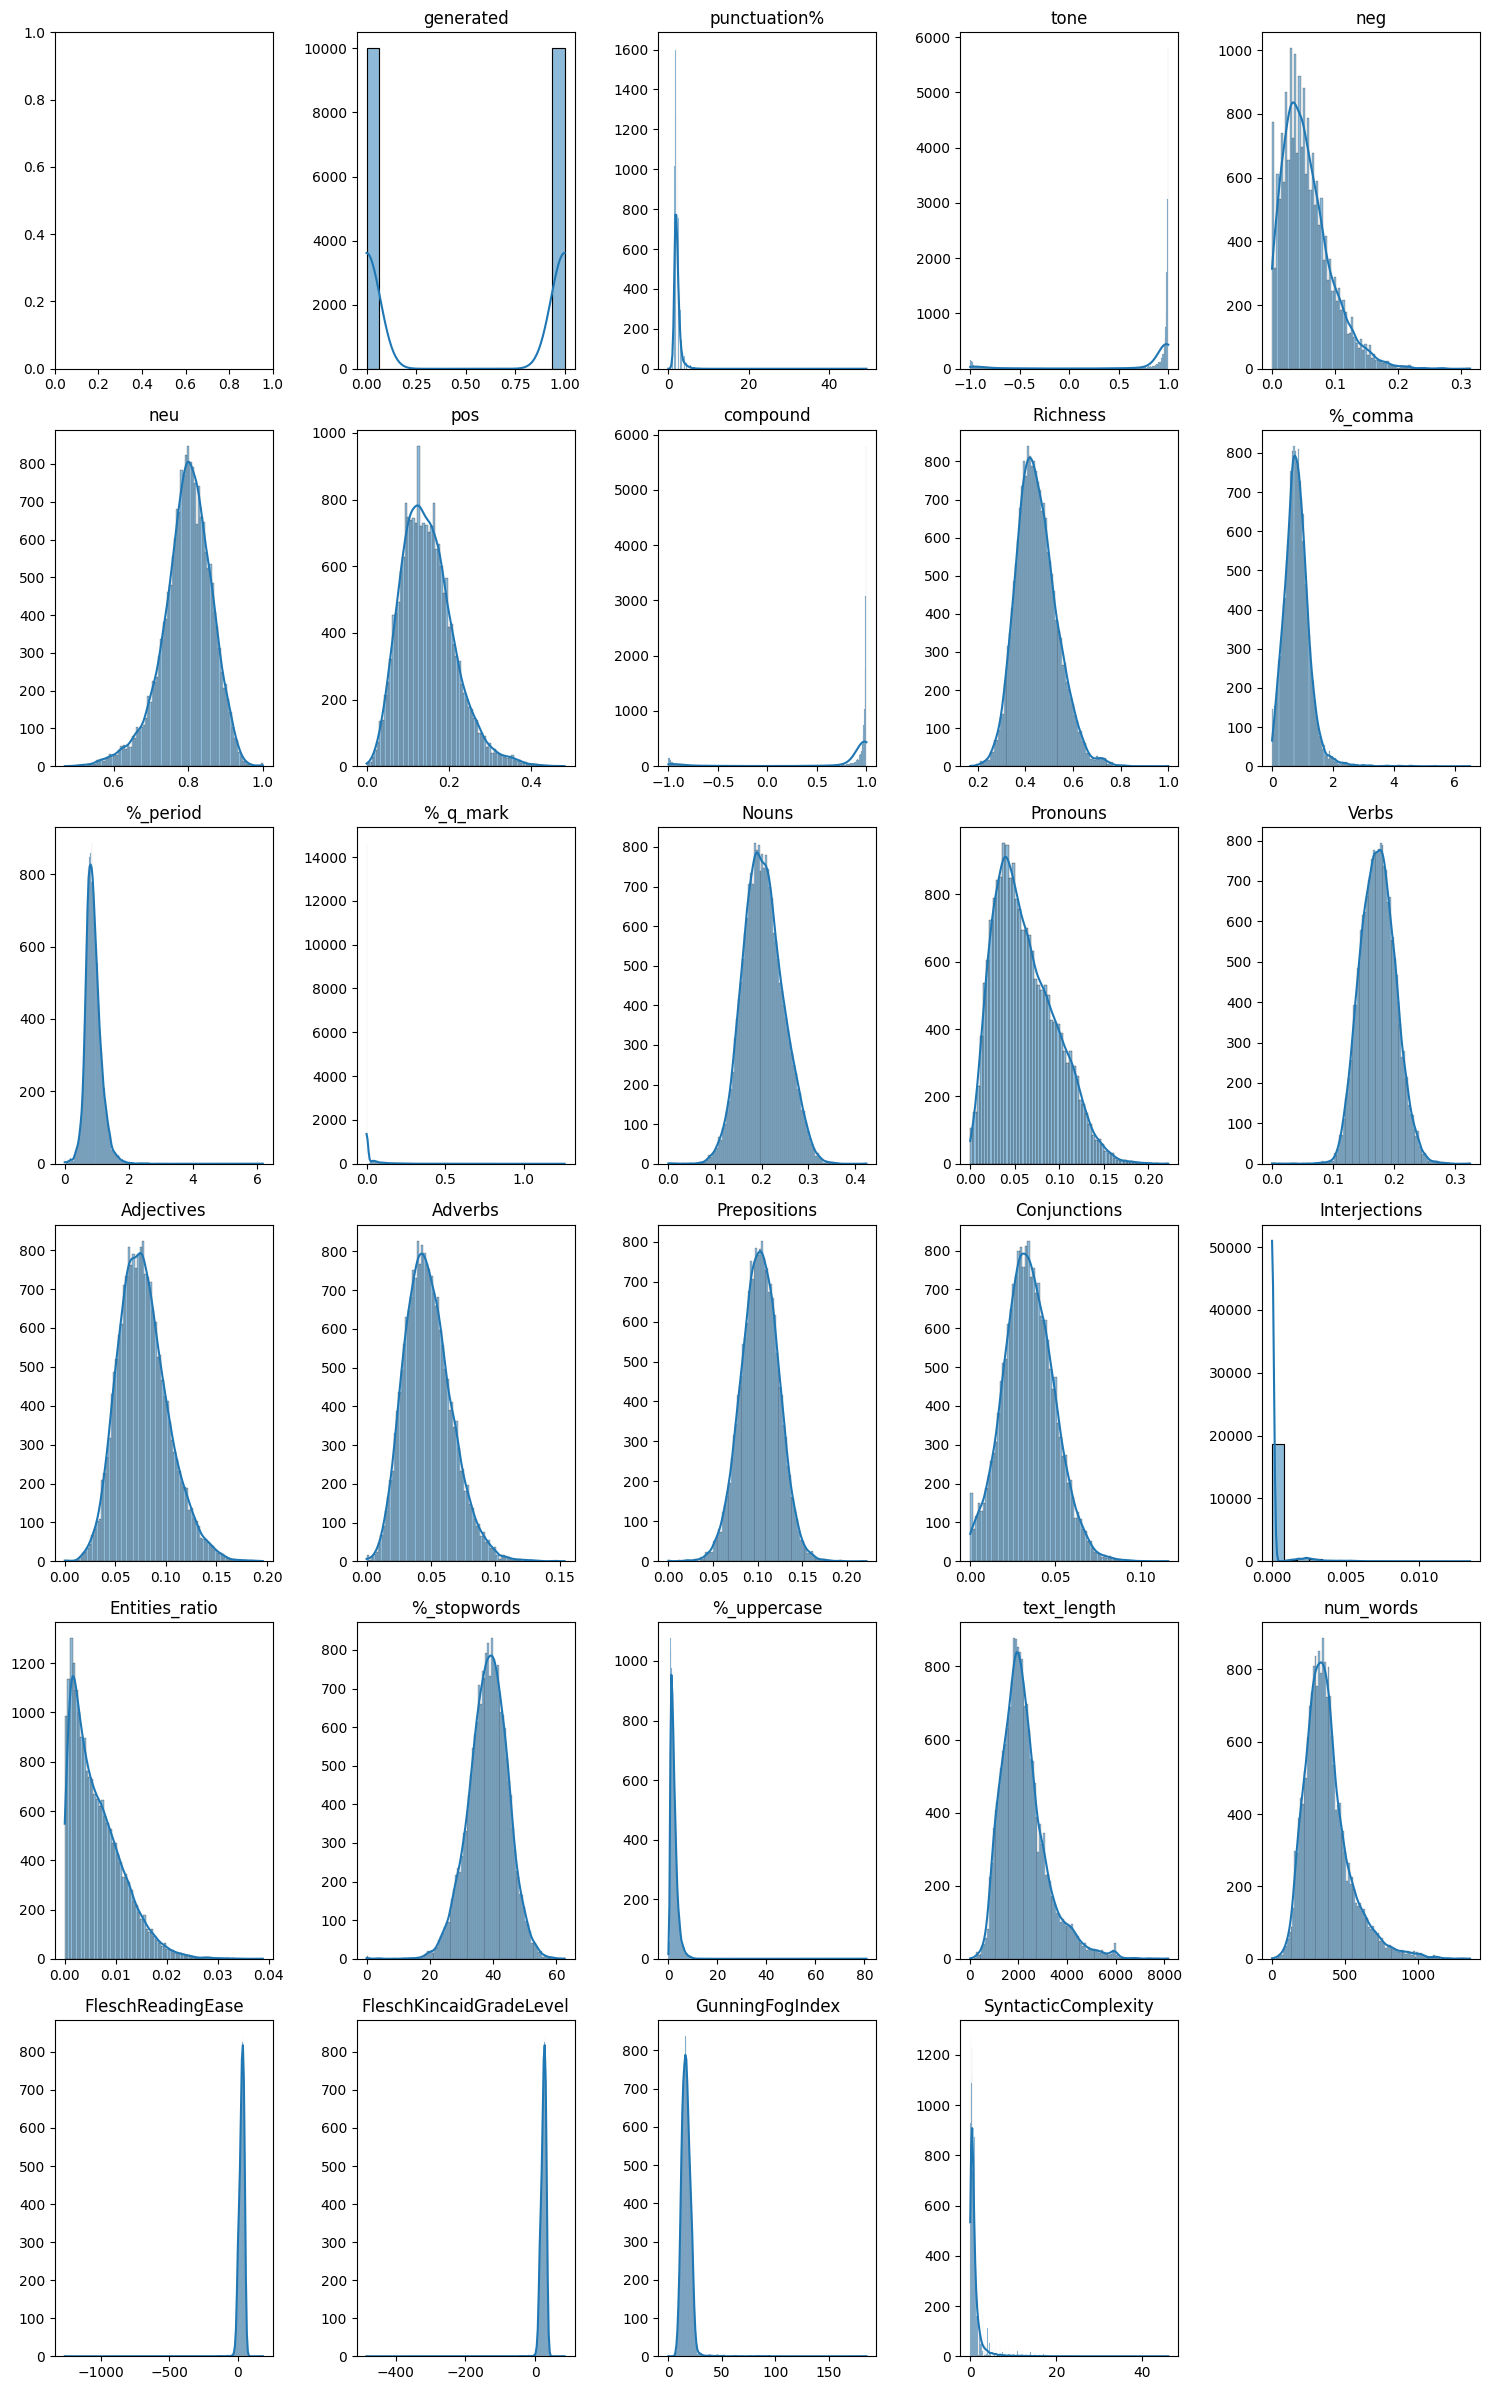

In [6]:
num_cols = 5  # Number of columns in the grid
num_rows = (len(data.columns) - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
axs = axs.flatten()

for i, col in enumerate(data.columns):
    if col != "text":
        sns.histplot(data=data, x=col, ax=axs[i], kde=True)
        axs[i].set_title(col)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")

# Hide empty subplots if any
for j in range(len(data.columns) - 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Cleaning the data

In [7]:
def check_for_nan(data):
  if data.isnull().sum().any() > 0:
    data.dropna(axis=0, inplace=True)

  return data

check_for_nan(data)
print(data.isnull().sum())
data['generated'] = data['generated'].astype(int)

text                       0
generated                  0
punctuation%               0
tone                       0
neg                        0
neu                        0
pos                        0
compound                   0
Richness                   0
%_comma                    0
%_period                   0
%_q_mark                   0
Nouns                      0
Pronouns                   0
Verbs                      0
Adjectives                 0
Adverbs                    0
Prepositions               0
Conjunctions               0
Interjections              0
Entities_ratio             0
%_stopwords                0
%_uppercase                0
text_length                0
num_words                  0
FleschReadingEase          0
FleschKincaidGradeLevel    0
GunningFogIndex            0
SyntacticComplexity        0
AverageSentenceLength      0
dtype: int64


### Preprocessing

train-validation-test split


In [8]:
X, y = data.drop(['generated'], axis=1), data['generated']

x_train, x_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)

##### Scaling

In [9]:
# saving 'text' feature and remove it from the data so the regularization will not remove it by mistake
x_train_text = x_train['text']
x_scaler = x_train.drop(['text'], axis=1)

scaler = StandardScaler()
scaler.fit_transform(x_scaler)

def scale(x, scaling_algo):
    x_text = x['text']
    x = x.drop(['text'], axis=1)
    x_scaled = scaling_algo.transform(x)
    x = pd.DataFrame(x_scaled, columns=x.columns, index=x.index)  # Keep original index
    return pd.concat([x_text, x], axis=1)

x_train = scale(x_train, scaler)
x_train.head(1)

,text,punctuation%,tone,neg,neu,pos,compound,Richness,%_comma,%_period,...,Entities_ratio,%_stopwords,%_uppercase,text_length,num_words,FleschReadingEase,FleschKincaidGradeLevel,GunningFogIndex,SyntacticComplexity,AverageSentenceLength
5894,In the beginning in the story it talks about h...,-0.321895,0.443928,1.32186,-2.054172,1.305518,0.443928,-0.618788,-1.952217,2.851481,...,-0.411357,-0.161885,-0.051478,-1.10081,-0.969732,1.278556,1.278556,-1.086758,-0.458123,-0.427635


##### Reagularization

In [ ]:
x_scaler = x_train.drop(['text'], axis=1) # x_train without text since Lasso works only on numbers

# Regularization using L1 (Lasso)- we want to perform feature selection and keep robutness to outliers
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
log_reg_l1.fit(x_scaler, y_train)

# select only features with weights higher than 0
selected_features_mask = log_reg_l1.coef_[0] != 0
selected_features = x_scaler.iloc[:, selected_features_mask]

for feature, coefficient in zip(x_scaler.columns, log_reg_l1.coef_[0]):
    print("Feature:", feature, "Coefficient:", coefficient)

# add 'text' to the final x_train df
x_train = pd.concat([x_train_text, selected_features], axis=1)

x_train.head(1)

##### Applying of validation and test

In [ ]:
x_val = scale(x_val, scaler)
x_test = scale(x_test, scaler)

x_val = x_val[x_train.columns]
x_test = x_test[x_train.columns]

##### Sanity check

In [ ]:
# Check if x_train, x_val, and x_test have the same columns
columns_consistent = np.array_equal(x_train.columns, x_val.columns) and np.array_equal(x_train.columns, x_test.columns)

# Check if any of the datasets contain NaN values
nan_train = x_train.isnull().any().any()
nan_val = x_val.isnull().any().any()
nan_test = x_test.isnull().any().any()

print("Columns consistent across datasets:", columns_consistent)
print("NaN values in x_train:", nan_train)
print("NaN values in x_val:", nan_val)
print("NaN values in x_test:", nan_test)


#### DOC2VEC


##### doc2vec creation using only x_train text


In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(x_train.text)]
max_epochs = 10
vec_size = 50
alpha = 0.025

model_doc2vec = Doc2Vec(tagged_data, vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
model_doc2vec.train(tagged_data, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

# add 'doc2vec' column according to the model to both x_train and x_test
x_train['doc2vec'] = [model_doc2vec.infer_vector(text.split()) for text in x_train['text']]
x_val['doc2vec'] = [model_doc2vec.infer_vector(text.split()) for text in x_val['text']]
x_test['doc2vec'] = [model_doc2vec.infer_vector(text.split()) for text in x_test['text']]

# drop 'text' column from both x_train and x_test after vectorizing the text
x_train.drop(columns=['text'], axis=1, inplace=True)
x_val.drop(columns=['text'], axis=1, inplace=True)
x_test.drop(columns=['text'], axis=1, inplace=True)

In [ ]:
x_train.head(3)

,punctuation%,tone,neg,pos,compound,Richness,%_comma,%_period,%_q_mark,Nouns,...,Entities_ratio,%_stopwords,text_length,num_words,FleschReadingEase,FleschKincaidGradeLevel,GunningFogIndex,SyntacticComplexity,AverageSentenceLength,doc2vec
5894,-0.321895,0.443928,1.321860,1.305518,0.443928,-0.618788,-1.952217,2.851481,-0.413943,-0.941745,...,-0.411357,-0.161885,-1.100810,-0.969732,1.278556,1.278556,-1.086758,-0.458123,-0.427635,"[1.005701, -1.4519452, -0.8693077, -0.63120455..."
3728,0.190919,0.457181,-0.260689,1.027894,0.457181,0.005639,1.093955,-0.428716,-0.413943,0.742376,...,-0.856319,-0.007366,-0.194560,-0.199011,0.122581,0.122581,-0.059053,0.072561,-0.111544,"[-0.8127286, -1.0511487, -0.13945982, 1.386123..."
8958,-0.321895,-2.423489,0.984595,-1.085136,-2.423489,0.321059,-0.816791,0.964771,-0.413943,-0.395344,...,1.355371,0.293260,-0.575014,-0.466534,0.556389,0.556389,-0.597245,-0.458123,-0.299672,"[-0.03555435, 0.1508762, -0.18769285, -0.42583..."


##### spread 'doc2vec' into features using vec_size columns per each entery in the vector


In [ ]:
def add_columns(x, vec_size):
  for i in range(vec_size):
    x[f'doc2vec_{i+1}'] = x['doc2vec'].apply(lambda v: v[i])
  return x

x_train = add_columns(x_train.copy(), vec_size)
x_val = add_columns(x_val.copy(), vec_size)
x_test = add_columns(x_test.copy(), vec_size)

x_train.drop(columns=['doc2vec'], axis=1, inplace=True)
x_val.drop(columns=['doc2vec'], axis=1, inplace=True)
x_test.drop(columns=['doc2vec'], axis=1, inplace=True)

### Modeling

##### Define parameters


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
    "KNN": {'n_neighbors': [3, 5, 7]},
    "SVM": {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1, 1, 10], 'probability': [True]},
    "AdaBoost": {'n_estimators': [50, 100, 200]},
    "Decision Tree": {'max_depth': [3, 5, 7]},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
}

##### modeling

In [ ]:
def classification_pipeline(name, model):

  print(f"Strating classification process for {name} model\n")
  grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
  print(f"Grid best Parameters are: {grid.get_params()}\n")
  grid.fit(x_train, y_train)
  y_pred = grid.predict(x_val)

  report = classification_report(y_val, y_pred)

  conf_matrix = confusion_matrix(y_val, y_pred)

  y_score = grid.predict_proba(x_val)[:,1]
  fpr, tpr, _ = roc_curve(y_val, y_score)
  roc_auc = auc(fpr, tpr)

  # Save precision, recall, f1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
  results = {
      "precision": precision,
      "recall": recall,
      "f1_score": f1_score
    }

  # Plot classification report, confusion matrix, ROC curve
  plt.figure(figsize=(25, 5))
  print(f"{name} Classification Report")
  print(report)

  plt.subplot(1, 2, 1)
  plt.title(f"{name} Confusion Matrix")
  sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  plt.subplot(1, 2, 2)
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f"{name} ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

  print("\n")

  return results

###### Results

Strating classification process for Logistic Regression model

Grid best Parameters are: {'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(), 'n_jobs': -1, 'param_grid': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
  

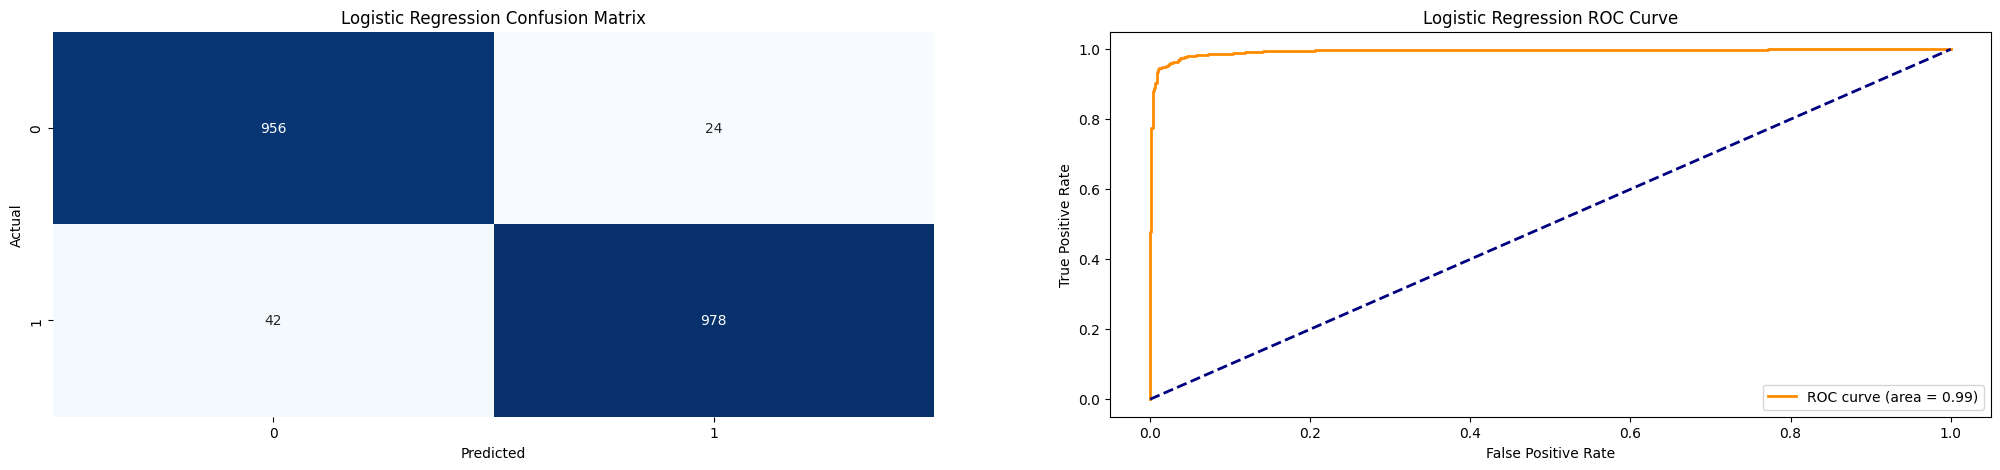



Strating classification process for KNN model

Grid best Parameters are: {'cv': 3, 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': -1, 'param_grid': {'n_neighbors': [3, 5, 7]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Fitting 3 folds for each of 3 candidates, totalling 9 fits
KNN Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       980
           1       0.95      0.98      0.97      1020

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



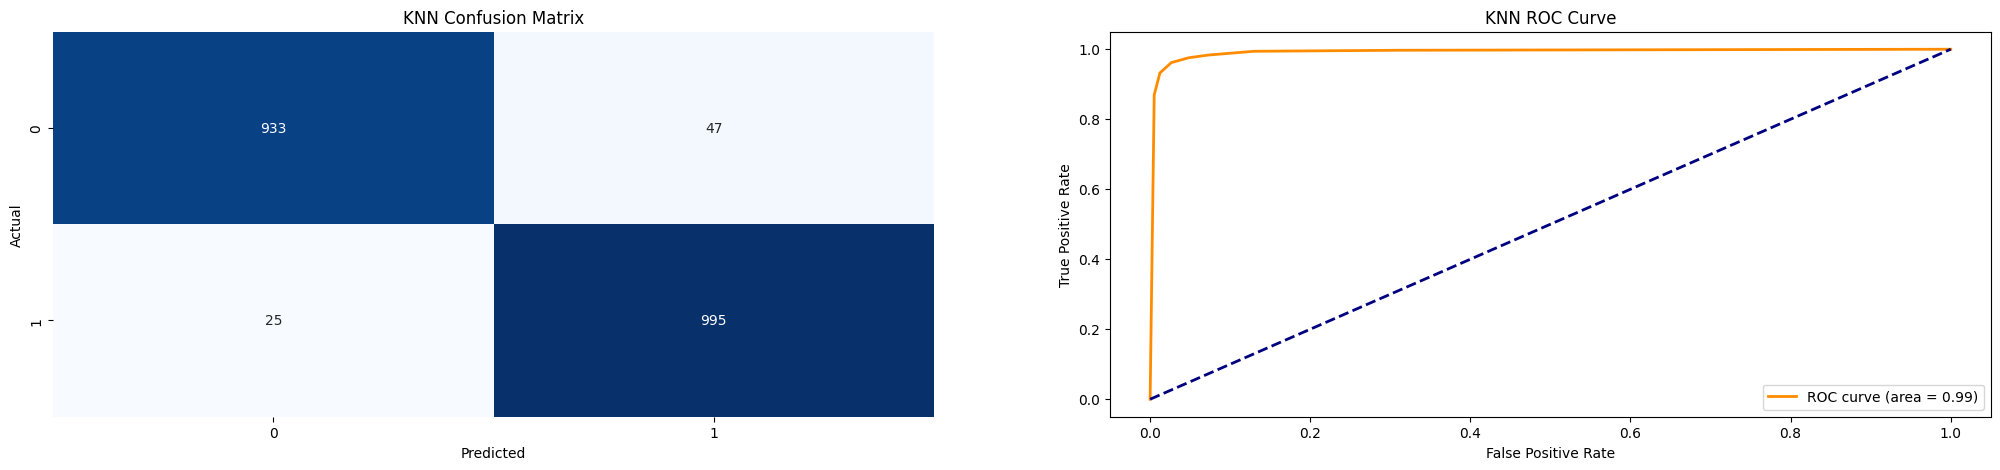



Strating classification process for SVM model

Grid best Parameters are: {'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(), 'n_jobs': -1, 'param_grid': {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1, 1, 10], 'probability': [True]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.

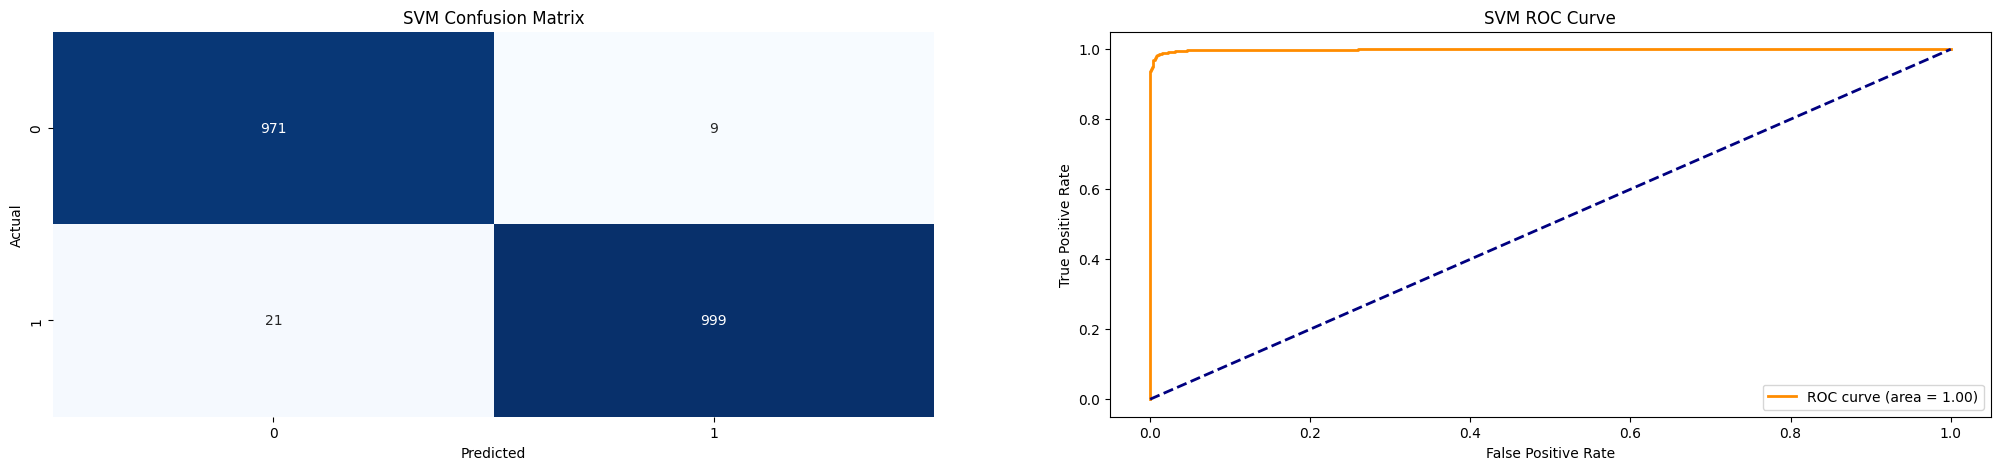



Strating classification process for AdaBoost model

Grid best Parameters are: {'cv': 3, 'error_score': nan, 'estimator__algorithm': 'SAMME.R', 'estimator__base_estimator': 'deprecated', 'estimator__estimator': None, 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 50, 'estimator__random_state': None, 'estimator': AdaBoostClassifier(), 'n_jobs': -1, 'param_grid': {'n_estimators': [50, 100, 200]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Fitting 3 folds for each of 3 candidates, totalling 9 fits
AdaBoost Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.97      0.97      1020

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



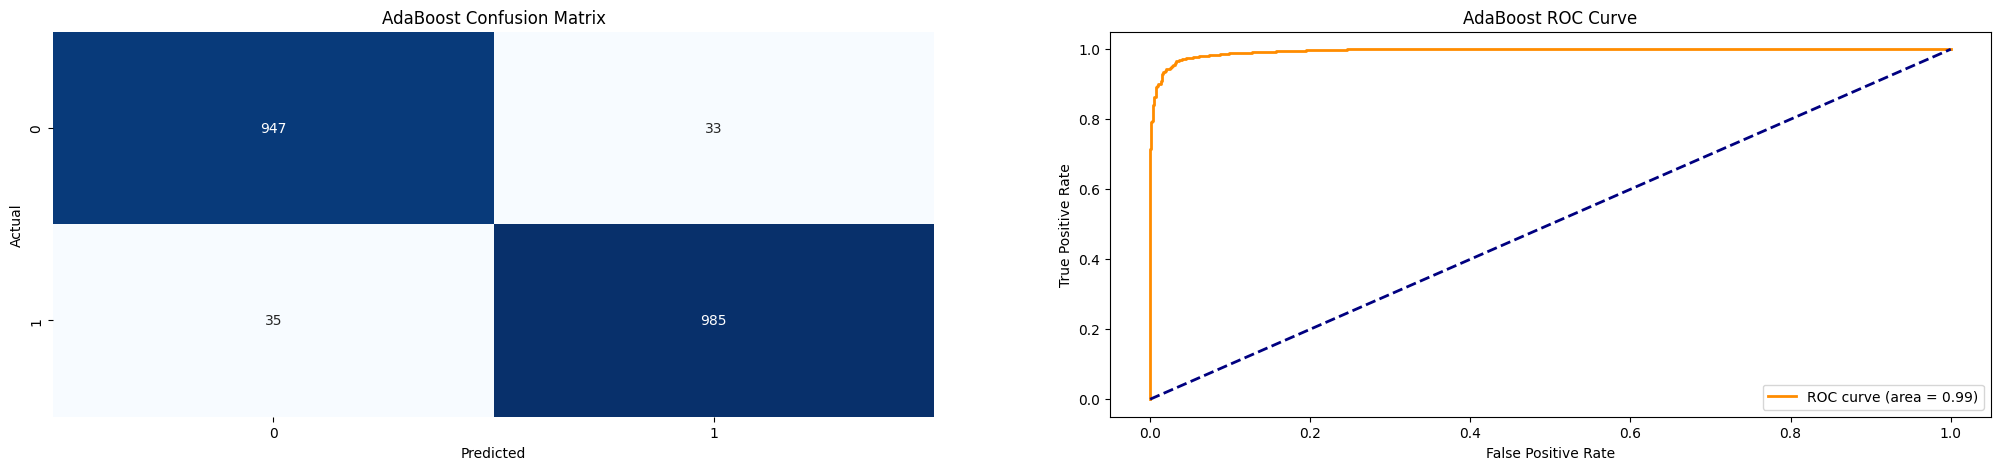



Strating classification process for Decision Tree model

Grid best Parameters are: {'cv': 3, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'n_jobs': -1, 'param_grid': {'max_depth': [3, 5, 7]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       980
           1       0.91      0.88      0.89      1020

    accuracy 

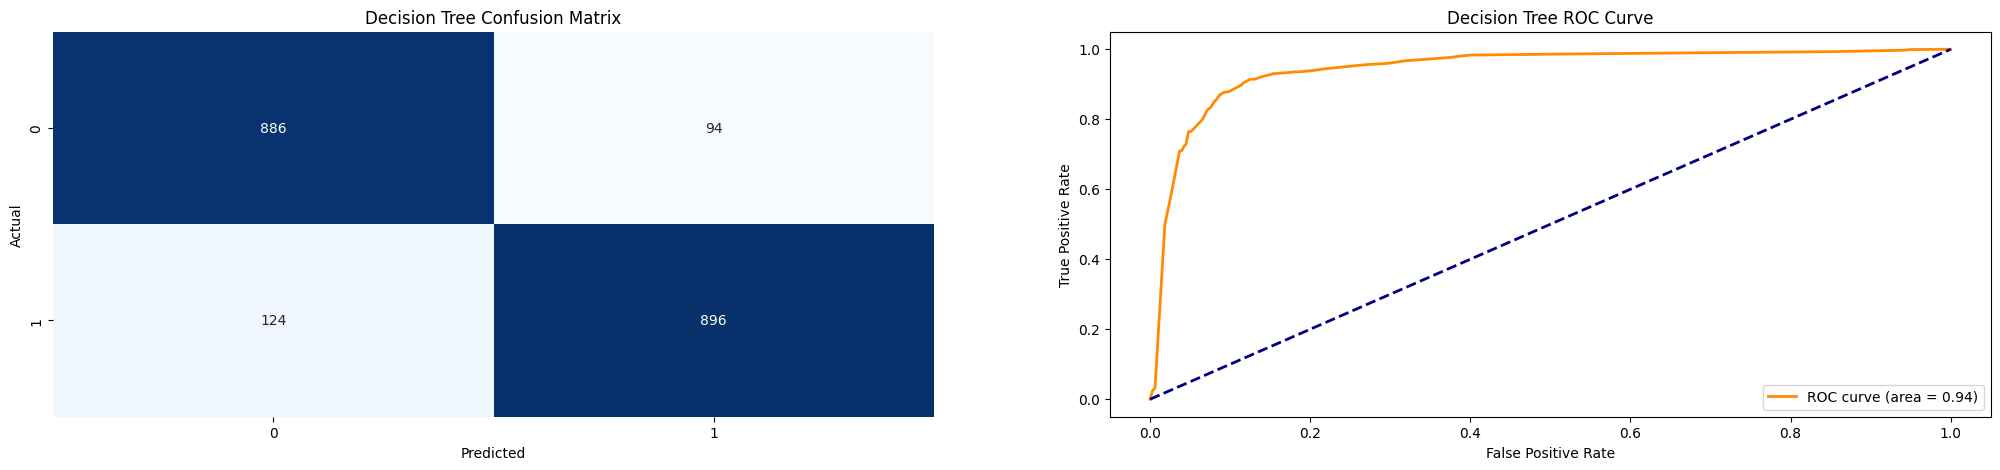



Strating classification process for Random Forest model

Grid best Parameters are: {'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(), 'n_jobs': -1, 'param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


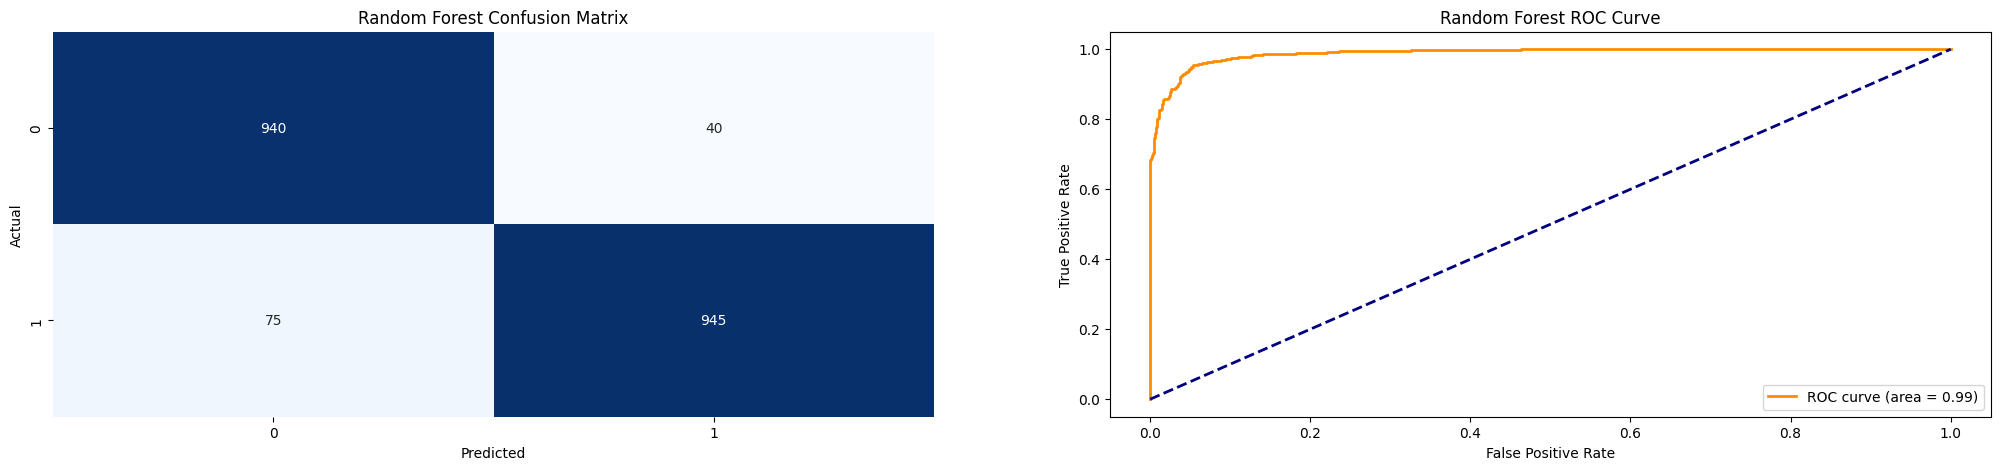

In [ ]:
all_results = {}

for name, model in models.items():
  all_results[name] = classification_pipeline(name, model)



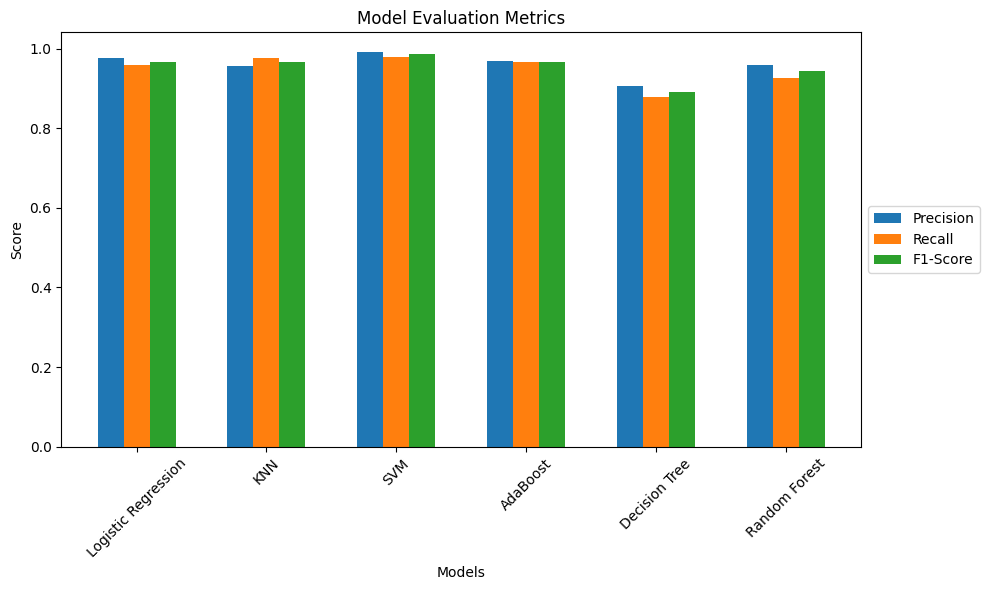

In [ ]:
plt.figure(figsize=(10, 6))
x = np.arange(len(all_results))
plt.bar(x, [all_results[model]["precision"] for model in models.keys()], width=0.2, label='Precision')
plt.bar(x + 0.2, [all_results[model]["recall"] for model in models.keys()], width=0.2, label='Recall')
plt.bar(x + 0.4, [all_results[model]["f1_score"] for model in models.keys()], width=0.2, label='F1-Score')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks(x + 0.2, models.keys(), rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

##### Create SVM model with best parameters


In [ ]:
best_params = {'C': 1.0, 'gamma': 'scale', 'probability': True}

svm_model = SVC(**best_params)

svm_model.fit(x_train, y_train)

In [ ]:
y_pred = svm_model.predict(x_val)

acc = accuracy_score(y_val, y_pred)

print(f"Accuracy: {acc}")

NameError: name 'svm_model' is not defined

##### Threshold
if the model thinks that the prob to be ai is greater than 80% it will classify it as ai, otherwise human


In [ ]:
y_pred_ai = (svm_model.predict_proba(x_val)[:, 1] > 0.80).astype(int)

acc = accuracy_score(y_val, y_pred_ai)

print(f"Accuracy: {acc}")

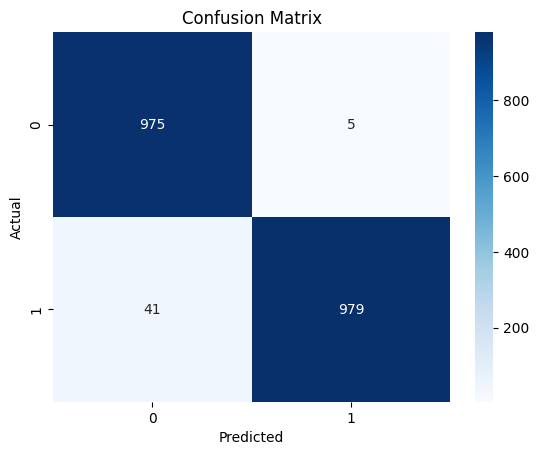

In [ ]:
cm = confusion_matrix(y_val, y_pred_ai)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
# save svm model as .pkl file
# with open('/content/drive/MyDrive/Colab Notebooks/svm_model.pkl', 'wb') as f:
#     pickle.dump(svm_model, f)

##### Demo

In [ ]:
example_text = "hello mister, I am the great figher."

def predict_generated(text_input):
  # convert to df pattern so "add_features" will deal with it
  df = pd.DataFrame({'text': [text_input], 'generated': [2]}) # 2 = 'unknown'

  # add the features from the text
  df = add_features(df)

  df.drop(['generated'], axis=1, inplace=True)

  df_text = df['text']

  with open('/content/drive/MyDrive/Colab Notebooks/scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)
  df = scale(df, scaler)

  # using L1 results of train
  selected_features = pd.Index(['text', 'punctuation%', 'tone', 'neg', 'pos', 'compound', 'Richness', '%_comma',
        '%_period', '%_q_mark', 'Nouns', 'Pronouns', 'Verbs', 'Adjectives',
        'Adverbs', 'Prepositions', 'Conjunctions', 'Interjections',
        'Entities_ratio', '%_stopwords', 'text_length', 'num_words',
        'FleschReadingEase', 'FleschKincaidGradeLevel', 'GunningFogIndex',
        'SyntacticComplexity', 'AverageSentenceLength'])

  df = df[selected_features]

  # Load the doc2vec model from the pickle file
  with open('/content/drive/MyDrive/Colab Notebooks/doc2vec_model.pkl', 'rb') as file:
      doc2vec_model = pickle.load(file)

  df['doc2vec'] = [doc2vec_model.infer_vector(df['text'])]

  # convert the vector to features
  df = add_columns(df.copy(), doc2vec_model.vector_size)

  # drop vector + text
  df.drop(columns=['doc2vec', 'text'], axis=1, inplace=True)

  with open('/content/drive/MyDrive/Colab Notebooks/svm_model.pkl', 'rb') as file:
      svm_ = pickle.load(file)

  # apply ideal SVM with 60% thereshold for Human
  y_pred = (svm_.predict_proba(df)[:, 1] > 0.60).astype(int)

  y_pred_map = np.where(y_pred == 1, "AI", "Human")
  print(f"{y_pred_map[0]} Generated")

predict_generated("Hello, I'm Dafna, and I'm originally from Ramat Gan, a lovely town known for its picturesque landscapes and vibrant community. I've spent most of my life here, surrounded by the beauty of nature and the warmth of the people. Living in Ramat Gan has shaped me in many ways, instilling in me a deep appreciation for simplicity, connection, and the little joys of life. Whether it's strolling through the town square, enjoying a cup of coffee at the local café, or simply taking in the sights and sounds of nature, there's always something special about being here. Ramat Gan isn't just a place I live in; it's a part of who I am, and I'm grateful for every moment spent in this wonderful town.")

AI Generated
